In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def generate_synthetic_events(num_events, sensor_height, sensor_width):
    timestamps = np.random.uniform(0, 1, num_events)
    x_coords = np.random.randint(0, sensor_height, num_events)
    y_coords = np.random.randint(0, sensor_width, num_events)
    polarities = np.random.choice([-1, 1], num_events)
    events = np.vstack((timestamps, x_coords, y_coords, polarities)).T
    return events

def normalize_events(events, sensor_height, sensor_width):
    min_t, max_t =  events[:, 0].min(), events[:, 0].max()

    # Normalize timestamp
    events[:, 0] = (events[:, 0] - min_t) / max_t - min_t

    # Normalize x, y coordinates
    events[:, 1] = events[:, 1] / sensor_height
    events[:, 2] = events[:, 2] / sensor_width
    return events

def visualize_spike_events(events):
    plt.figure(figsize=(12, 8))

    # Sort events by timestamp
    sorted_events = events[events[:, 0].argsort()]

    # Plot each event
    for i, event in enumerate(sorted_events):
        if event[3] == 1:  # Positive polarity
            plt.plot(event[0], event[1], 'ro', markersize=2)  # Red dot
        else:  # Negative polarity
            plt.plot(event[0], event[1], 'bo', markersize=2)  # Blue dot
    
    plt.xlabel('Normalized Time')
    plt.ylabel('Normalized X Coordinate')
    plt.title('Spike Events Over Time')
    plt.show()




In [2]:
class LIFNeuron:
    def __init__(self, tau_m, V_rest, V_thresh, V_reset, R, dt):
        self.tau_m = tau_m
        self.V_rest = V_rest
        self.V_thresh = V_thresh
        self.V_reset = V_reset
        self.R = R
        self.dt = dt
        self.V = V_rest
        self.spike_times = []

    def update(self, I, t):
        dV = (-(self.V - self.V_rest) + self.R * I) * (self.dt / self.tau_m)
        self.V += dV

        if self.V >= self.V_thresh:
            self.V = self.V_reset
            self.spike_times.append(t)
    
    def simulate(self, I, T):
        time = np.arange(0, T, self.dt)
        V_trace = []
        for t in time:
            self.update(I(t), t)
            V_trace.append(self.V)
        return time, np.array(V_trace), self.spike_times

def generate_input_current(events, I_0, tau_s, T, dt):
    time = np.arange(0, T, dt)
    I = np.zeros_like(time)
    
    for event in events:
        t_event = event[0] * T  # scale event time to simulation duration
        spike_time_index = int(t_event / dt)
        I[spike_time_index:] += I_0 * np.exp(-(time[spike_time_index:] - t_event) / tau_s)
    
    return lambda t: I[int(t / dt)], time, I


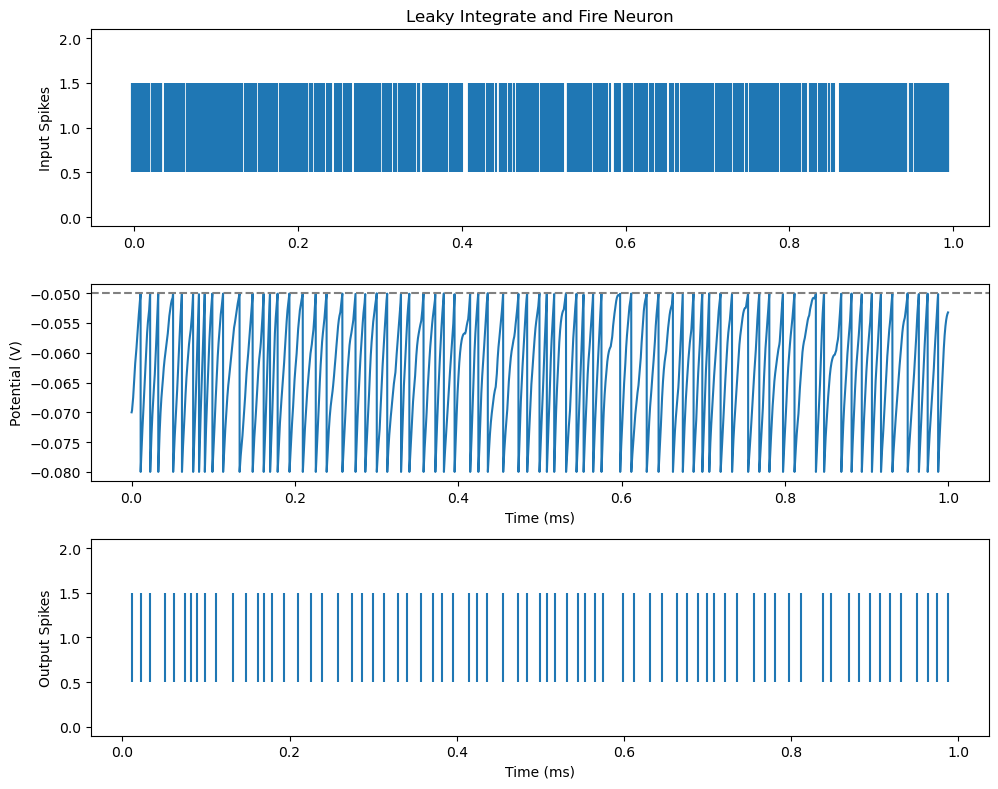

In [3]:
# Parameters
num_events = 1000
sensor_width = 240
sensor_height = 180
tau_m = 20e-3  # 20 ms
V_rest = -70e-3  # -70 mV
V_thresh = -50e-3  # -50 mV
V_reset = -80e-3  # -80 mV
R = 1e7  # 10 MOhm
dt = 1e-4  # 0.1 ms
T = 1.0  # 1 second simulation
I_0 = 1e-9  # 1 nA
tau_s = 5e-3  # 5 ms

# Generate and normalize events
events = generate_synthetic_events(num_events, sensor_width, sensor_height)
normalized_events = normalize_events(events, sensor_width, sensor_height)

# Generate input current
I, input_time, input_current = generate_input_current(normalized_events, I_0, tau_s, T, dt)

# Create and simulate LIF neuron
neuron = LIFNeuron(tau_m, V_rest, V_thresh, V_reset, R, dt)
time, V_trace, spike_times = neuron.simulate(I, T)

# Plot results
plt.figure(figsize=(10, 8))

# Plot input spikes
plt.subplot(3, 1, 1)
input_spike_times = normalized_events[:, 0] * T
plt.eventplot(input_spike_times, orientation='horizontal')
plt.ylabel('Input Spikes')
plt.title('Leaky Integrate and Fire Neuron')

# Plot membrane potential
plt.subplot(3, 1, 2)
plt.plot(time, V_trace)
plt.axhline(V_thresh, color='gray', linestyle='--', label='Threshold')
plt.xlabel('Time (ms)')
plt.ylabel('Potential (V)')

# Plot output spikes
plt.subplot(3, 1, 3)
plt.eventplot(spike_times, orientation='horizontal')
plt.xlabel('Time (ms)')
plt.ylabel('Output Spikes')

plt.tight_layout()
plt.show()